In [1]:
import zipfile
import os

zip_path = 'project_data.zip'
extract_dir = 'project_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


Unzipped to: project_data


In [3]:
class_dirs = os.listdir(extract_dir)
print("Classes:", class_dirs)

Classes: ['backpack', 'book', 'calculator', 'chair', 'clock', 'desk', 'keychain', 'laptop', 'paper', 'pen', 'phone', 'water bottle']


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# https://pytorch.org/vision/main/transforms.html

transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=extract_dir, transform=transform)
dataSize = len(dataset)

# https://pytorch.org/docs/stable/data.html
trainSize = int(0.8 * dataSize)
valSize = int(0.1 * dataSize)
testSize = dataSize - trainSize - valSize
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [trainSize, valSize, testSize]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))

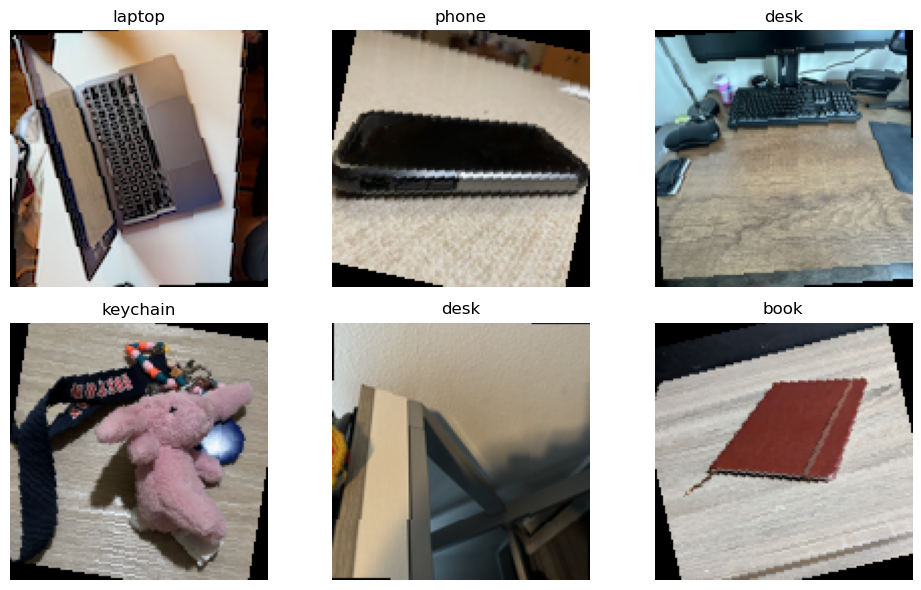

In [15]:
import matplotlib.pyplot as plt
import torchvision

class_names = dataset.classes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show 6 images
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(6):
    ax = axes[i // 3, i % 3]
    img = images[i].permute(1, 2, 0)
    img = img * 0.5 + 0.5
    ax.imshow(img)
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [33]:
import torch.nn as nn
import torch.nn.functional as F

# https://www.youtube.com/watch?v=aO9naT4IFKI

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=12)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) # flattens arrays
        x = self.fc_model(x)

        return x
            


In [35]:
model = CNN()

In [37]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=12, bias=True)
  )
)

In [39]:
import torch

# Check if GPU is available with CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training and inference with device: {device}')

model.to(device)  # Move model to GPU

Training and inference with device: cpu


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=12, bias=True)
  )
)

In [41]:
import torch.optim as optim

# excercise 8
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.2f}, Accuracy: {100 * correct / total:.2f}%")
        

Epoch 1/5, Loss: 273.38, Accuracy: 20.50%
Epoch 2/5, Loss: 261.49, Accuracy: 24.76%
Epoch 3/5, Loss: 253.47, Accuracy: 28.12%
Epoch 4/5, Loss: 248.15, Accuracy: 30.22%
Epoch 5/5, Loss: 241.33, Accuracy: 31.98%


In [43]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Validation Accuracy: 30.95%


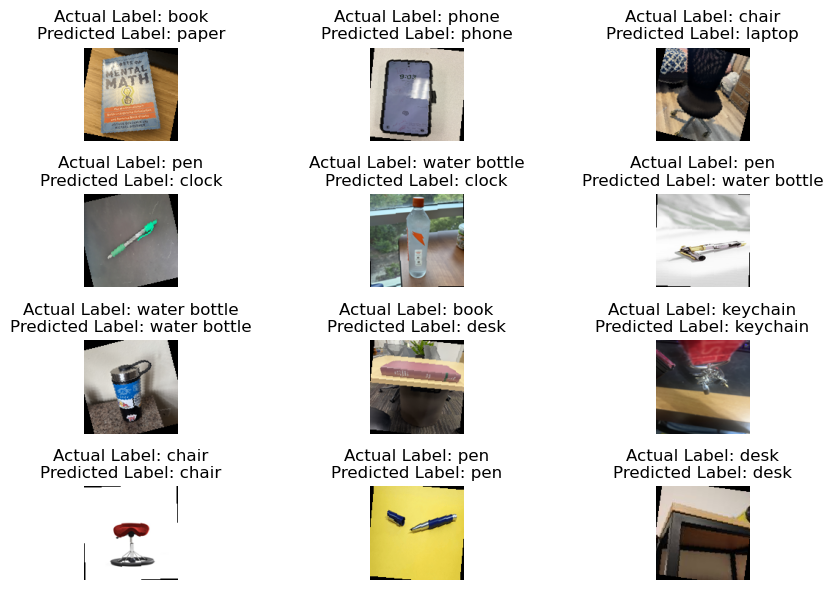

In [51]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6))
for i in range(12):
    ax = axes[i // 3, i % 3]
    img = images[i].permute(1, 2, 0)
    img = img * 0.5 + 0.5  # unnormalize from [-1, 1] → [0, 1]
    ax.imshow(img)
    ax.set_title(f"Actual Label: {class_names[labels[i]]}\nPredicted Label: {class_names[predicted[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()